# Recurrent Neural Network Simulating a Dynamic System

In [77]:
! pip3 install sympy matplotlib

## 1. Definition of a Dynamic Process

Classes DynamicModel and DynamicProcess are defined file DynamicSystem.py. DynamicModel holds a description of a dynamic system in a symbolic form and as a differential equation. DynamicProcess helps to model a response (time series) of such model for a random input.   

In [1]:
from sympy.abc import s, t, y, x, y, z

In [2]:
from DynamicSystem import DynamicModel, DynamicProcess

### 1.1 Symbolic Definition of a Chosen System

In [3]:
G = 5*(s+1)/((s+3)*(s+2))
dynamic_model = DynamicModel(G)

In [4]:
dynamic_process = DynamicProcess(dynamic_model, 100)
dynamic_process.model

(5*s + 5)/((s + 2)*(s + 3))

### 1.2. Example of system responses for different inputs 

In [5]:
import matplotlib.pyplot as plt
import numpy as np

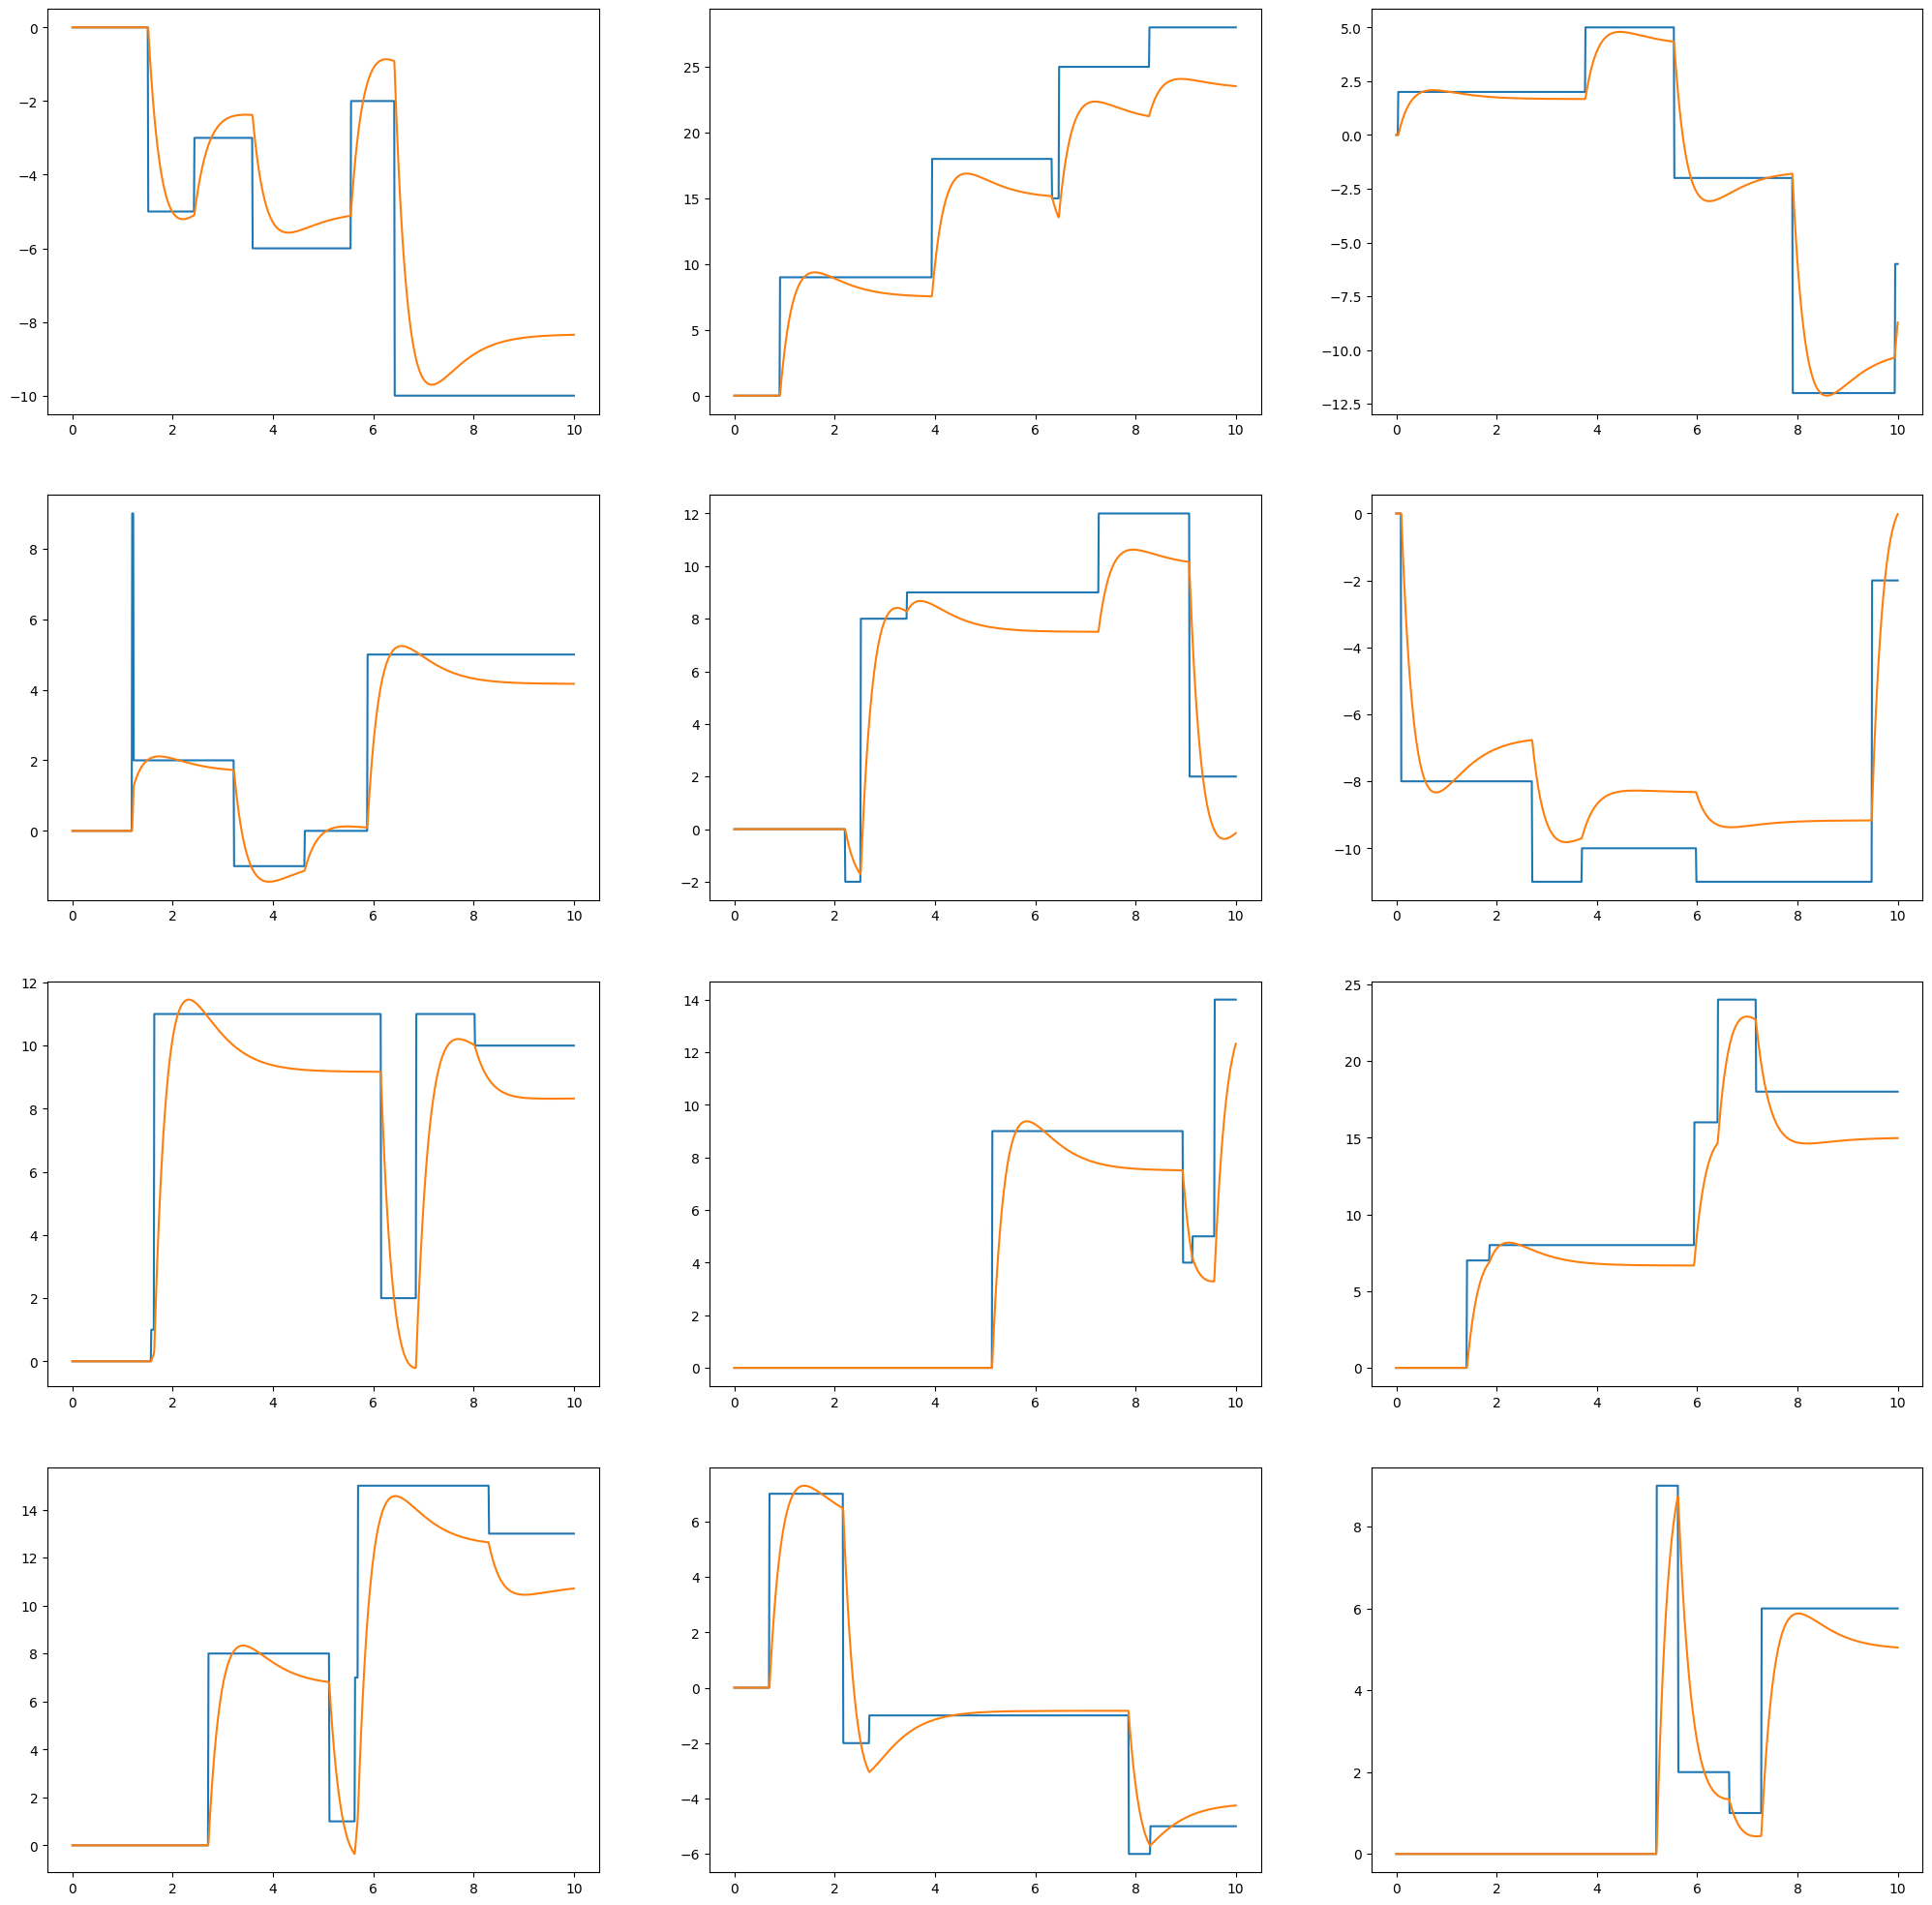

In [284]:
plt.figure(figsize=(25,25))
for i in range(12):
    t, u, y = dynamic_process.generate_time_series(10, 1000, new_inputs=True)
    plt.subplot(4,3,i+1)
    plt.plot(t, u)
    plt.plot(t, y)
plt.show()

## 2. Generate and Save Dataset

In [6]:
import pandas as pd
import os

In [7]:
start = 60
stop = 80
for i in range(start, stop):
    t, u, y = dynamic_process.generate_time_series(10, 1000, new_inputs=True)
    data = {'t':t, 'u':u, 'y':y}
    df = pd.DataFrame(data)
    
    # Save to csv
    df.to_csv(f'dataset/{i}.csv', index=False)
    
    # Save to pymongo
    # time_series_collection.insert_one(df.to_json())

### 2.1. Prepare Dataset

In [8]:
import tensorflow as tf
from tensorflow import keras

2022-11-03 21:49:00.101238: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-03 21:49:00.833222: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-03 21:49:00.833280: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-11-03 21:49:00.976841: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-03 21:49:02.651632: W tensorflow/stream_executor/platform/de

#### 2.1.1. Load files

In [11]:
dataset_path = 'dataset/'
dataset_files = [ f'{dataset_path}/{file}' for file in os.listdir(dataset_path) if 'csv' in file]

val_samples = round(len(dataset_files) * 0.2)
train_ds = dataset_files[:-val_samples]
val_ds = dataset_files[-val_samples:]

### 2.1. BatchBuilder

Class that creates batches of values for training and validation based on windows size. 

In [12]:
class TimeSeriesBatchBuilder(keras.utils.Sequence):
    """_summary_
    Helps to iterate over the dataset
    Args:
        keras (_type_): _description_
    """

    def __init__(self, dataset_files, window_size):
        self.dataset_files = dataset_files
        self.window_size = window_size
        self.file_len = len(pd.read_csv(self.dataset_files[0]))
        self.batch_size = self.file_len / self.window_size
    
    def __len__(self):
        return len(self.dataset_files)

    def __getitem__(self, idx):
        """Returns tuple (input, output) that corresponds to batch idx"""
        
        i = idx * self.batch_size
        batch_file = pd.read_csv(self.dataset_files[idx])
        
        x, y = [], []
        end = self.file_len - self.window_size
        for i in range(self.window_size, end):
            # x_temp = np.concatenate((batch_file['u'][i:i+self.window_size].values, batch_file['y'][i:i+self.window_size].values))
            
            y_actual = batch_file['y'][i:i+self.window_size].values
            if i==0:
                y_prev = np.zeros(self.window_size)
            else:
                y_prev = batch_file['y'][i-1:i+self.window_size-1].values
            
            x_temp = np.array([batch_file['u'][i:i+self.window_size].values, y_actual, y_actual-y_prev])
            x.append(x_temp)
            y.append(batch_file['y'][i+self.window_size])
        
        return np.array(x, dtype=np.float32), np.array(y, dtype=np.float32)

In [13]:
WINDOW_SIZE = 15
train_gen = TimeSeriesBatchBuilder(train_ds, window_size=WINDOW_SIZE)
val_gen = TimeSeriesBatchBuilder(val_ds, window_size=WINDOW_SIZE)

In [14]:
x, y = train_gen.__getitem__(0)

In [15]:
x.shape

(970, 3, 15)

In [16]:
x[300]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
      dtype=float32)

In [17]:
y[0]

0.0

### Prepare Baseline model for benchmarking

In [174]:
class Baseline():

  def predict(self, inputs):
    return [[inputs[-1]]]

In [175]:
baseline_model = Baseline()

In [176]:
baseline_model.predict([1, 2, 3, 4])

[[4]]

## 3. Recurrent Neural Network

In [18]:
import tensorflow as tf
from keras.layers import Dropout
from keras.layers import Dense, LSTM, Input, Conv1D, SimpleRNN
from keras.optimizers import Adam
from keras.metrics import RootMeanSquaredError, MeanAbsoluteError
from keras.models import Sequential

### 3.1. Definitions of models

Models with different types of cells. 
- Standard Deep Neural Network (dnn)
- Convolutional Neural Network, which performs 1D filtering on each input vector (window)
- SimpleRNN - Recurrent Neural Netowrk - cell that keeps information about past values. 
- LSTM - long-short term memory cell, extension of RNN
- Custom model - a combination of different types of cells

In [19]:
def base_model(input_shape):
  pass


def dnn_model(input_shape, layers, units, dropout, loss, optimizer, metrics):
  
  model = Sequential()
  model.add(Input(shape=input_shape))
  for _ in range(layers):
    model.add(Dense(units=units))
    model.add(Dropout(rate=dropout))
  model.add(Dense(units=1))
  
  model.compile(loss=loss,
                optimizer=optimizer,
                metrics=metrics)
  model.summary()
  
  return model


def cnn_model(input_shape, layers, units, dropout, loss, optimizer, metrics):
  CONV_WIDTH = 3
  
  model = Sequential()
  model.add(Input(shape=input_shape))
  for _ in range(layers):
    model.add(Conv1D(filters=units, activation='relu', kernel_size=(CONV_WIDTH)))
    model.add(Dropout(rate=dropout))
  model.add(Dense(units=1))
  
  model.compile(loss=loss,
                optimizer=optimizer,
                metrics=metrics)
  model.summary()
  
  return model


def lstm_model(input_shape, layers, units, dropout, loss, optimizer, metrics):

  model = Sequential()
  # model.add(Input(shape=input_shape))
  model.add(LSTM(units=units, input_shape=input_shape, return_sequences=True))
  for _ in range(layers-1):
    model.add(LSTM(units=units, return_sequences=True))
    model.add(Dropout(rate=dropout))
    
  model.add(LSTM(units=units, return_sequences=False))
  model.add(Dropout(rate=dropout))
  model.add(Dense(units=1))
  
  model.compile(loss=loss,
                optimizer=optimizer,
                metrics=metrics)
  model.summary()
    
  return model 


def rnn_model(input_shape, layers, units, dropout, loss, optimizer, metrics):

  model = Sequential()
  model.add(Input(shape=input_shape))
  for _ in range(layers-1):
    model.add(SimpleRNN(units=units, return_sequences=True))
    model.add(Dropout(rate=dropout))
    
  model.add(SimpleRNN(units=units, return_sequences=False))

  model.add(Dense(units=1))
  model.compile(loss=loss,
                optimizer=optimizer,
                metrics=metrics)
  model.summary()
    
  return model 


def custom_model(input_shape, layers, units, dropout, loss, optimizer, metrics):
  
  model = Sequential()
  model.add(Input(shape=input_shape))
  for _ in range(layers-1):
    model.add(LSTM(units=units, return_sequences=True))
    model.add(Dropout(rate=dropout))
    
  model.add(SimpleRNN(units=128, return_sequences=False))

  model.add(Dense(units=1))
  model.compile(loss=loss,
                optimizer=optimizer,
                metrics=metrics)
  model.summary()
    
    
  return model 

In [20]:
learning_rate = 0.001

# Add patiance

params = {
    'input_shape': (3, WINDOW_SIZE),
    'layers': 8,
    'units': 128,
    'dropout': 0.2,
	'loss': 'mean_squared_error',
	'optimizer': 'adam',
    'metrics': [RootMeanSquaredError(), MeanAbsoluteError()],
}

2022-11-03 21:55:36.948805: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-11-03 21:55:36.949247: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-03 21:55:36.949433: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (DESKTOP-Szymon): /proc/driver/nvidia/version does not exist
2022-11-03 21:55:36.950618: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


#### 3.1.1. List of defined and compiled models

In [21]:
models = {
    # 'dnn': dnn_model(**params),
    # 'cnn': cnn_model(**params),
    # 'rnn': rnn_model(**params),
    'lstm': lstm_model(**params),
    # 'custom': custom_model(**params)
}

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 3, 128)            73728     
                                                                 
 lstm_1 (LSTM)               (None, 3, 128)            131584    
                                                                 
 dropout (Dropout)           (None, 3, 128)            0         
                                                                 
 lstm_2 (LSTM)               (None, 3, 128)            131584    
                                                                 
 dropout_1 (Dropout)         (None, 3, 128)            0         
                                                                 
 lstm_3 (LSTM)               (None, 3, 128)            131584    
                                                                 
 dropout_2 (Dropout)         (None, 3, 128)            0

# 4. Training

## 4.1. Loss visualization

In [22]:
def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    # plt.show()

## 4.2. Training each model

Training each type of model

In [23]:
from IPython.display import clear_output
from keras.callbacks import ModelCheckpoint

In [24]:
# to_train = ['dnn', 'cnn', 'lstm', 'rnn', 'custom']
to_train = ['lstm']

In [25]:
filepath= 'best_current_models/{0}/weights.hdf5'

In [26]:
models['lstm'].load_weights(filepath.format('lstm'))

In [27]:
EPOCHS=50

In [39]:
histories = {}
for i, name in enumerate(to_train):
    print(f'Training {name.upper()}')
    checkpoint = ModelCheckpoint(filepath.format(name), monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='auto')
    histories[name] = models[name].fit(train_gen, epochs=EPOCHS, validation_data=val_gen, shuffle=False, callbacks=[checkpoint], use_multiprocessing=True)
    # clear_output()

Training LSTM
Epoch 1/50
64/64 [==============================] - 41s 629ms/step - loss: 0.5027 - root_mean_squared_error: 0.7090 - mean_absolute_error: 0.4519 - val_loss: 0.1045 - val_root_mean_squared_error: 0.3232 - val_mean_absolute_error: 0.2342
Epoch 2/50
64/64 [==============================] - 41s 630ms/step - loss: 0.4956 - root_mean_squared_error: 0.7040 - mean_absolute_error: 0.4471 - val_loss: 0.1048 - val_root_mean_squared_error: 0.3237 - val_mean_absolute_error: 0.2202
Epoch 3/50
64/64 [==============================] - 36s 560ms/step - loss: 0.4346 - root_mean_squared_error: 0.6592 - mean_absolute_error: 0.4197 - val_loss: 0.0871 - val_root_mean_squared_error: 0.2951 - val_mean_absolute_error: 0.2139
Epoch 4/50
64/64 [==============================] - 36s 554ms/step - loss: 0.3329 - root_mean_squared_error: 0.5769 - mean_absolute_error: 0.3802 - val_loss: 0.1443 - val_root_mean_squared_error: 0.3799 - val_mean_absolute_error: 0.2125
Epoch 5/50
64/64 [====================

In [35]:
lstm = lstm_model(**params)
lstm.load_weights(filepath.format('lstm'))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 3, 128)            73728     
                                                                 
 lstm_10 (LSTM)              (None, 3, 128)            131584    
                                                                 
 dropout_8 (Dropout)         (None, 3, 128)            0         
                                                                 
 lstm_11 (LSTM)              (None, 3, 128)            131584    
                                                                 
 dropout_9 (Dropout)         (None, 3, 128)            0         
                                                                 
 lstm_12 (LSTM)              (None, 3, 128)            131584    
                                                                 
 dropout_10 (Dropout)        (None, 3, 128)           

Training history of each model

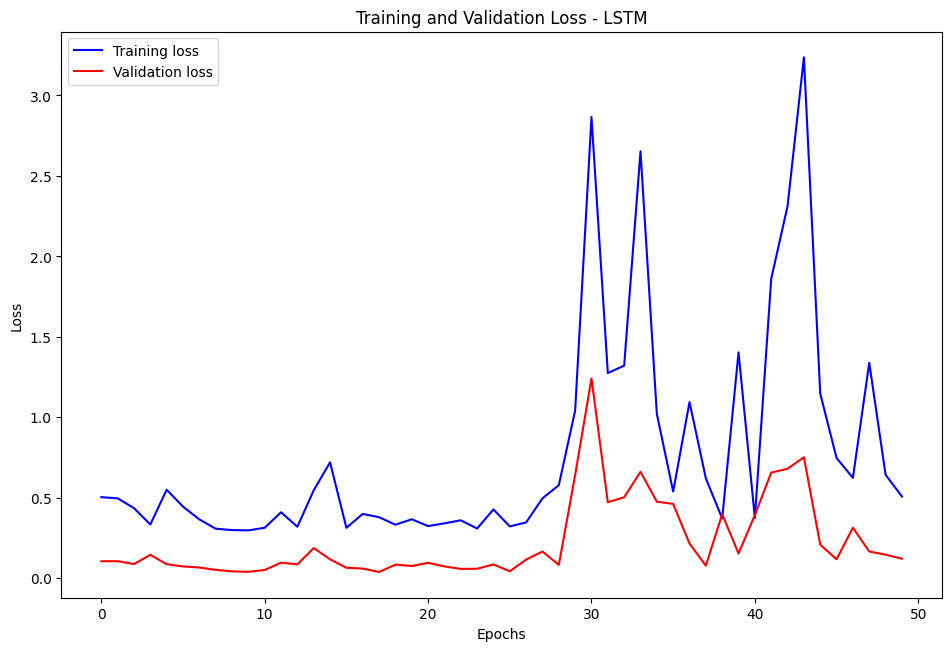

In [40]:
i=1
plt.figure(figsize=(25,25))
for name, history in histories.items():
    plt.subplot(3,2,i)
    visualize_loss(history, f'Training and Validation Loss - {name.upper()}')
    i+=1
plt.show()

# 5. Testing

## 5.1. Generating test time series

In [226]:
t, u, y = dynamic_process.generate_time_series(10, 1000, new_inputs=True)

In [31]:
def create_full_prediction(t, u, y, model, window_size=15):
    y_pred = []
    u_extended = np.concatenate((np.zeros(window_size), u))
    y_window = np.zeros(window_size)
    for i in range(len(t)):
        
        # input_for_pred = np.array([np.concatenate((u_extended[i:i+window_size], y_window))])
        
        if i==0:
            y_window_prev = np.zeros(window_size)
        
        input_for_pred = np.array([[u_extended[i:i+window_size], y_window, y_window-y_window_prev]])
        
        # input_for_pred = np.array([u_extended[i:i+window_size]])
        y_hat = model.predict(input_for_pred)[0][0]
        y_pred.append(y_hat)
        
        y_window_prev = y_window
        y_window = np.roll(y_window, -1)
        y_window[window_size-1] = y_hat
        
    return y_pred

## 5.2. Prediction of specific model

In [228]:
prediction = create_full_prediction(t, u, y, models['custom'], window_size=WINDOW_SIZE)

1/1 [==============================] - 0s 47ms/step


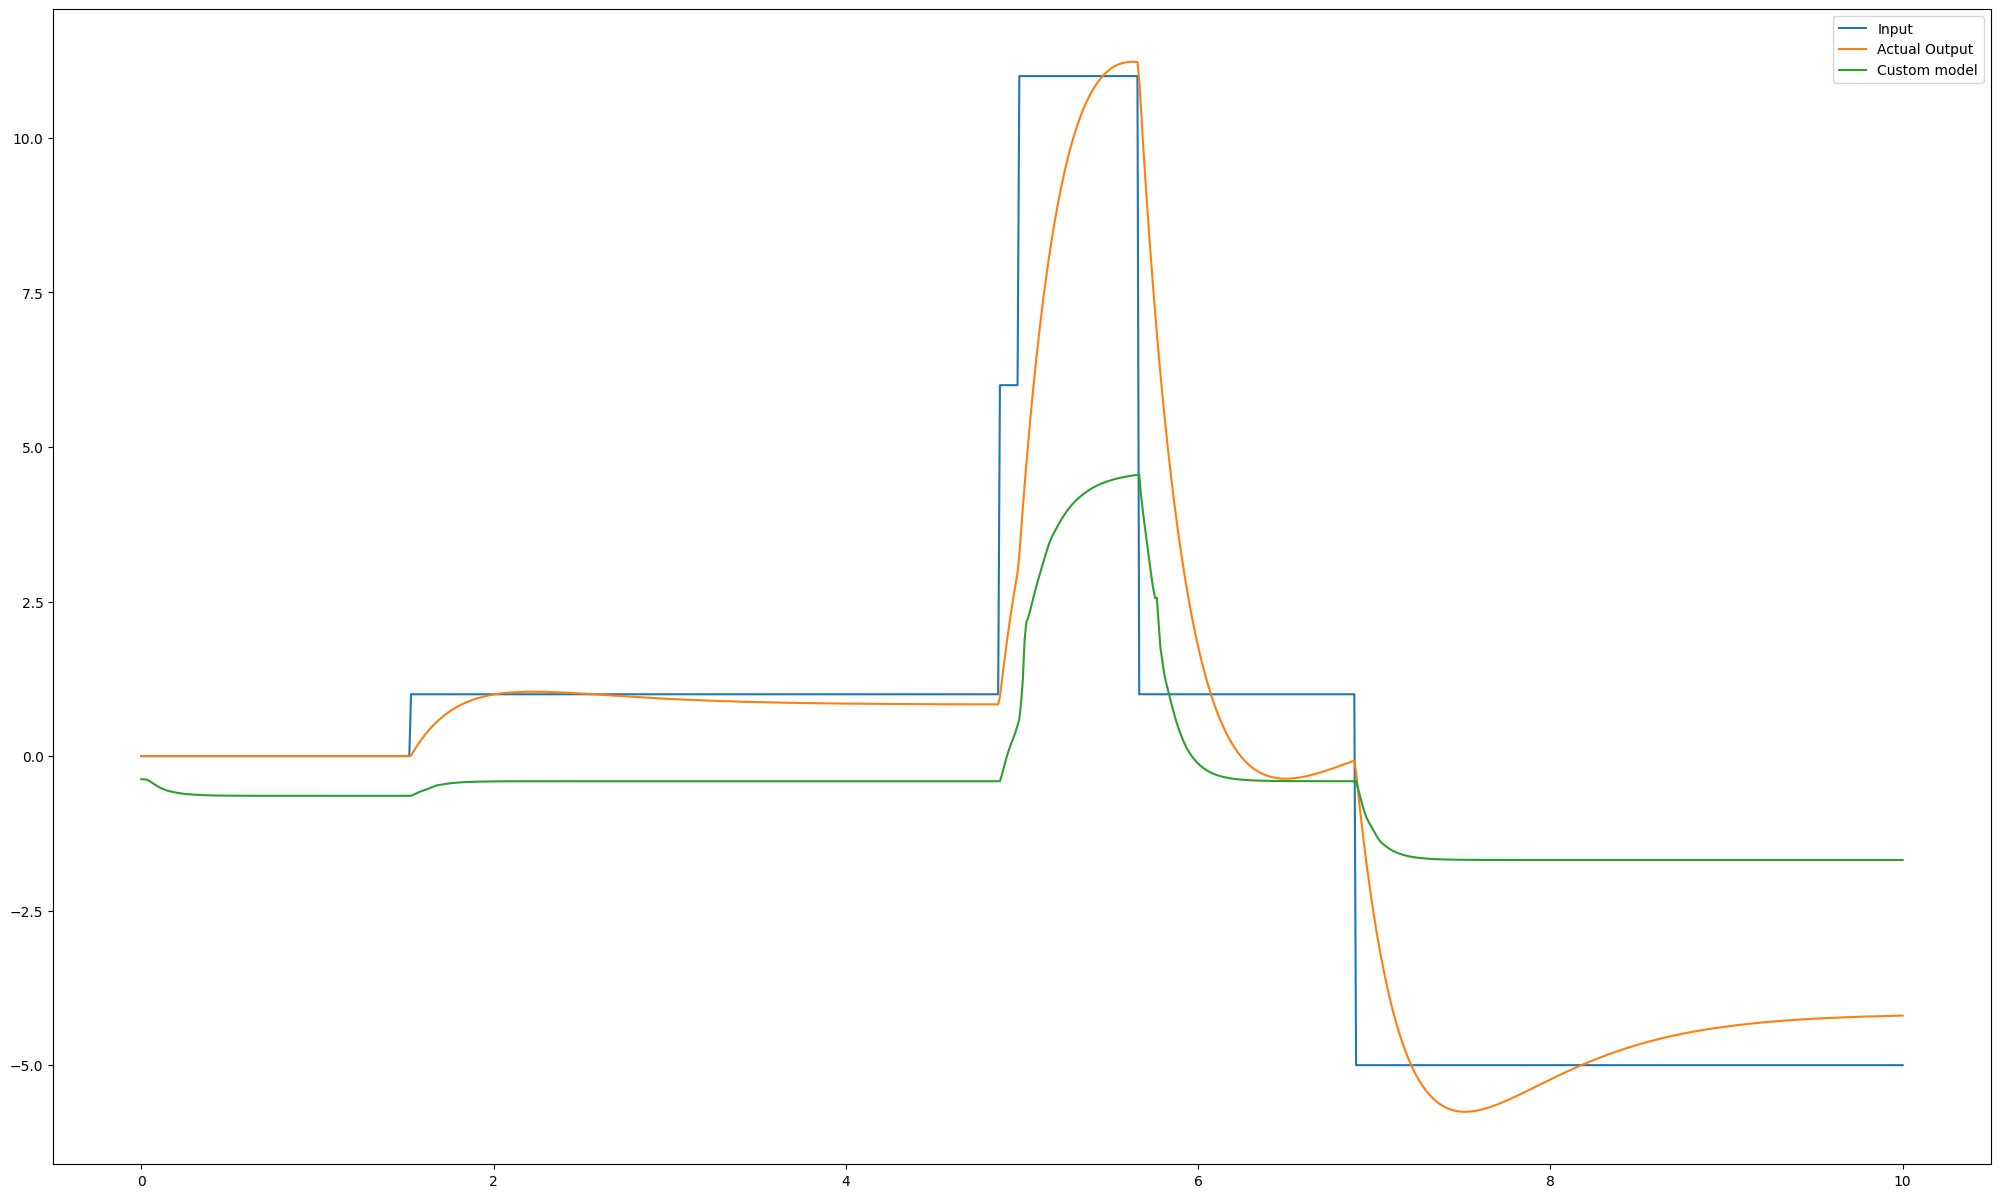

In [236]:
plt.figure(figsize=(25,15))
plt.plot(t, u)
plt.plot(t, y)
plt.plot(t, prediction)
plt.legend(['Input', 'Actual Output','Custom model'])
plt.show()

## 5.3. Predict and compare all models

In [230]:
predictions = {}
for name, model in models.items():
    predictions[name] = create_full_prediction(t, u, y, model, window_size=WINDOW_SIZE)

1/1 [==============================] - 0s 51ms/step


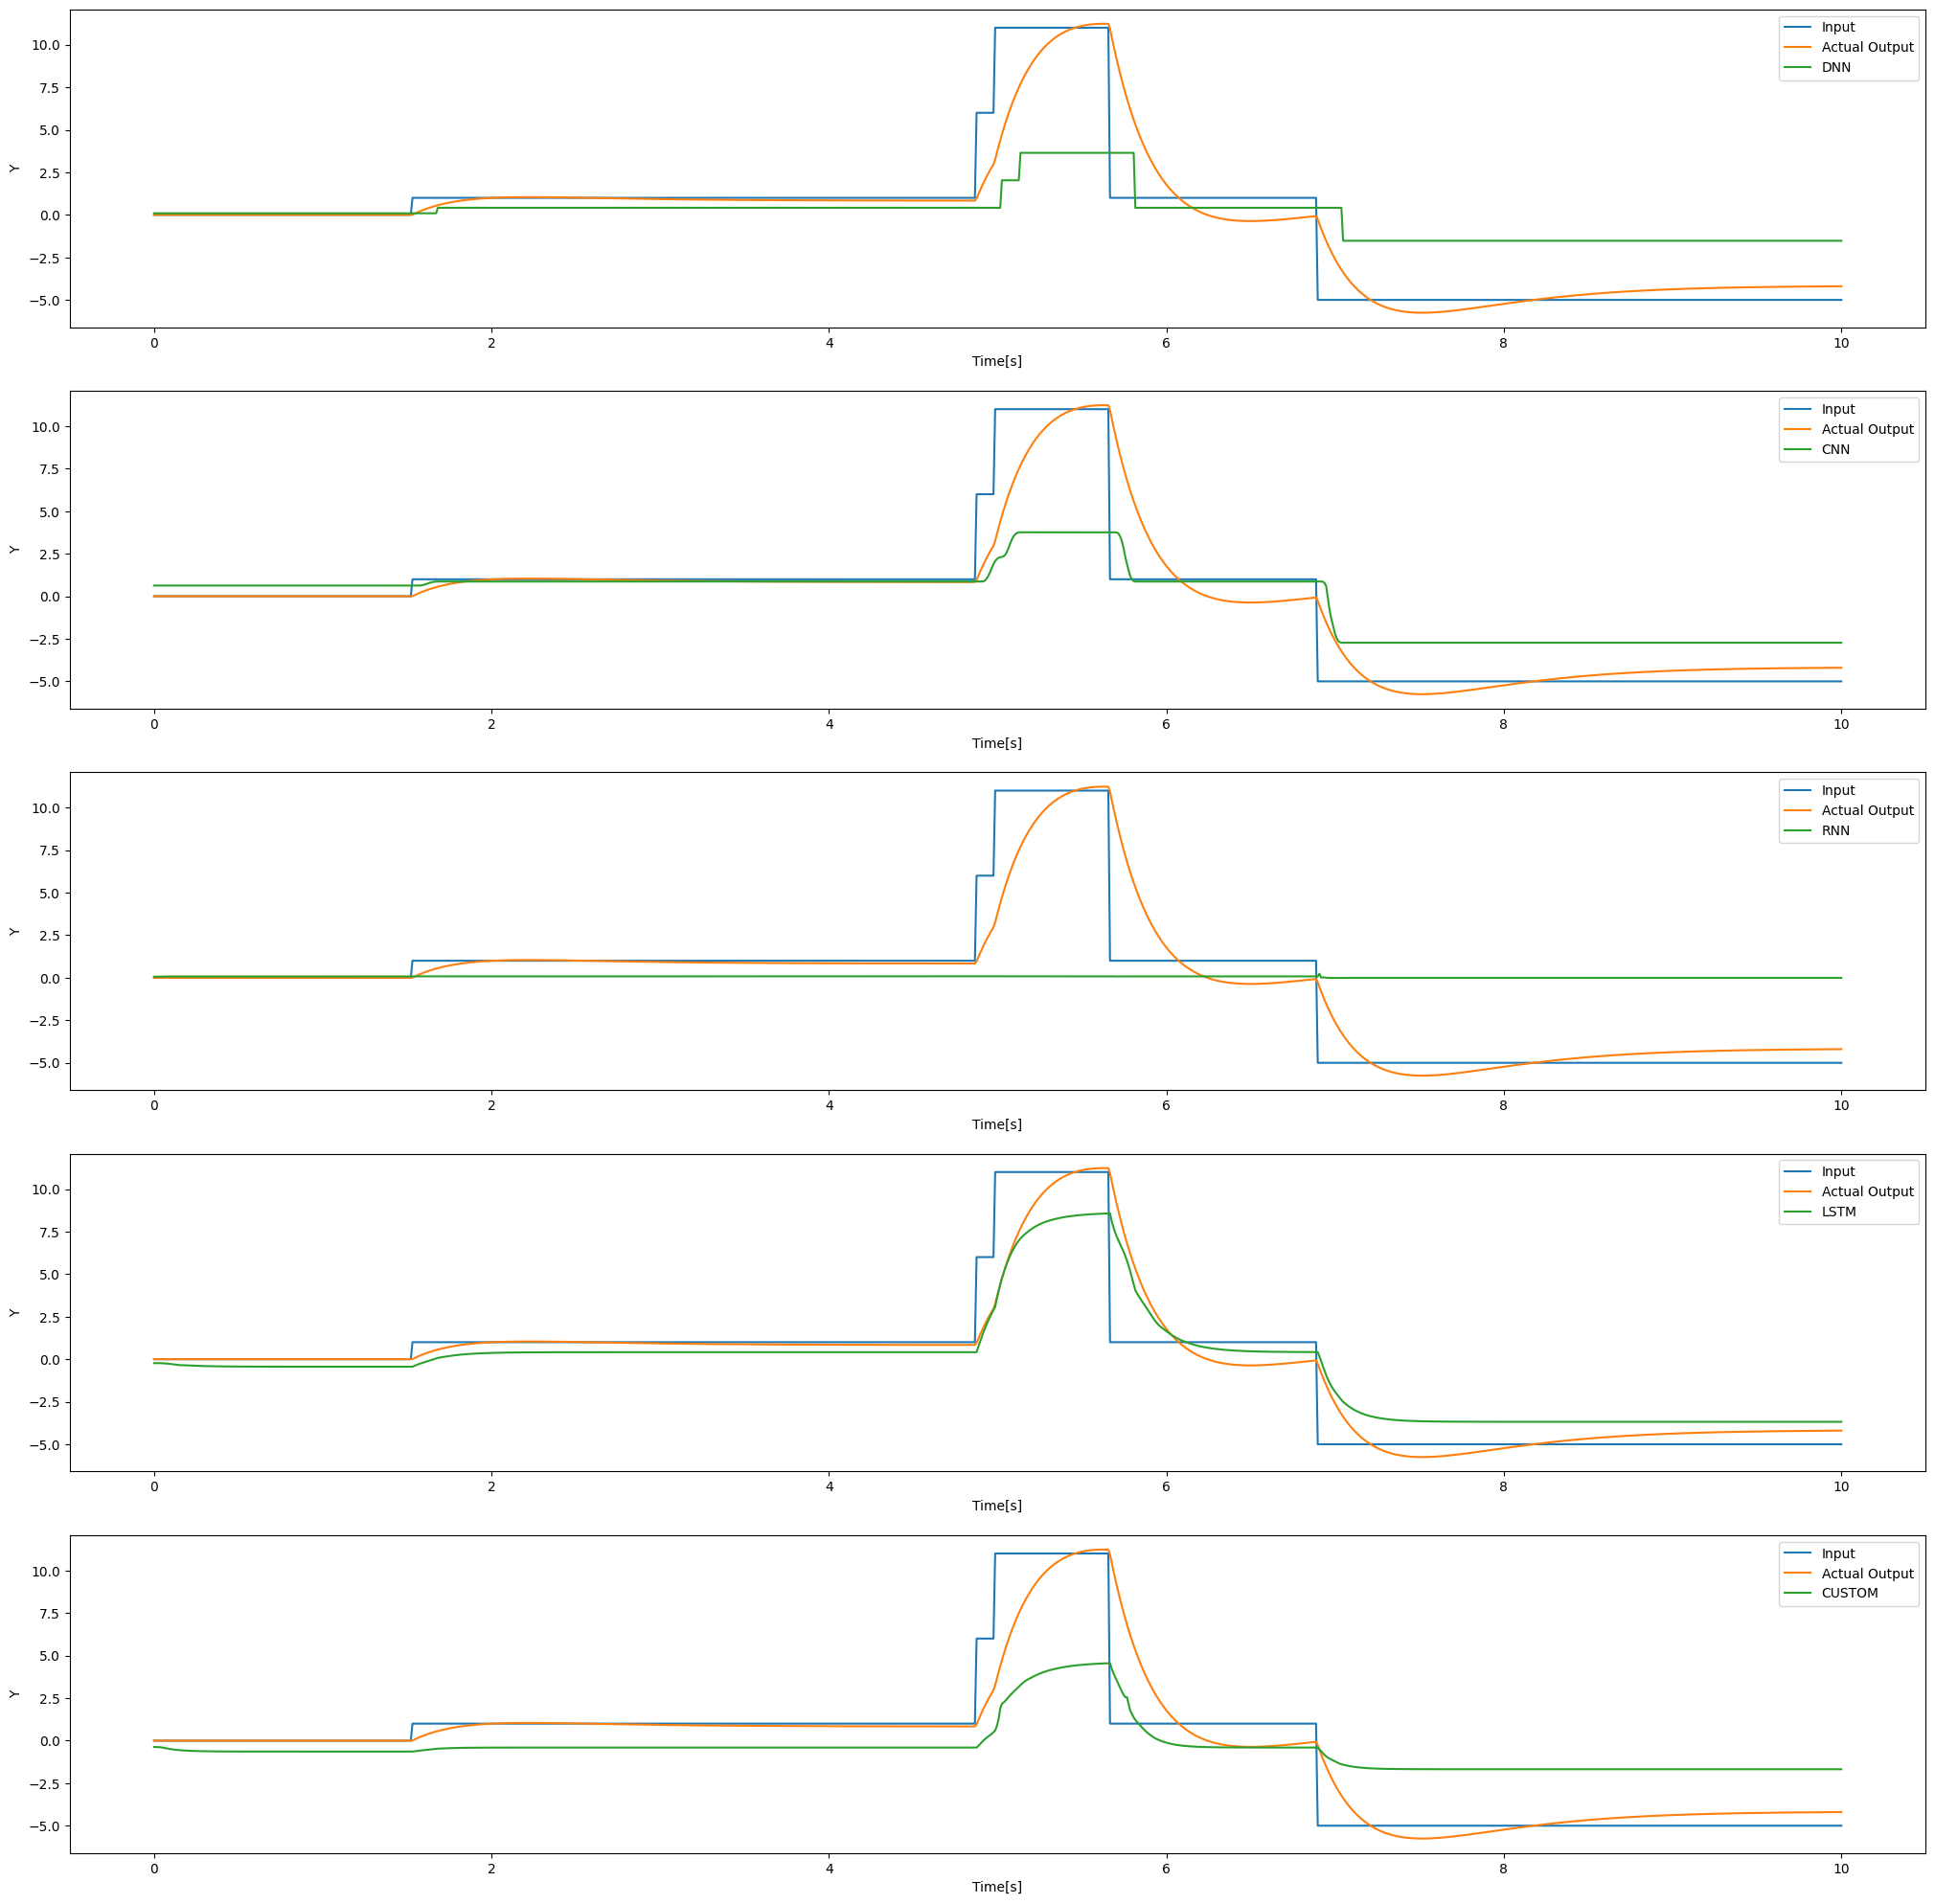

In [232]:
i=1
plt.figure(figsize=(25,25))
for name, prediction in predictions.items():
    plt.subplot(5,1,i)
    plt.plot(t, u)
    plt.plot(t, y)
    plt.plot(t, prediction)
    plt.xlabel('Time[s]')
    plt.ylabel('Y')
    plt.legend(['Input', 'Actual Output', name.upper()])
    i+=1
plt.show()

So far, the best performing model was the one created with only LSTM. 

In [36]:
simulations = []
predictions = []
for i in range(4):
    # Generate new simulations
    # t, u, y = dynamic_process.generate_time_series(10, 1000, new_inputs=True)
    
    # Read simulations from validation dataset
    df = pd.read_csv(val_ds[i])
    t, u, y = df['t'].values, df['u'].values, df['y'].values
    
    simulations.append([t, u, y])
    predictions.append(create_full_prediction(t, u, y, lstm, window_size=WINDOW_SIZE))
    models['lstm'].reset_states()

1/1 [==============================] - 0s 42ms/step


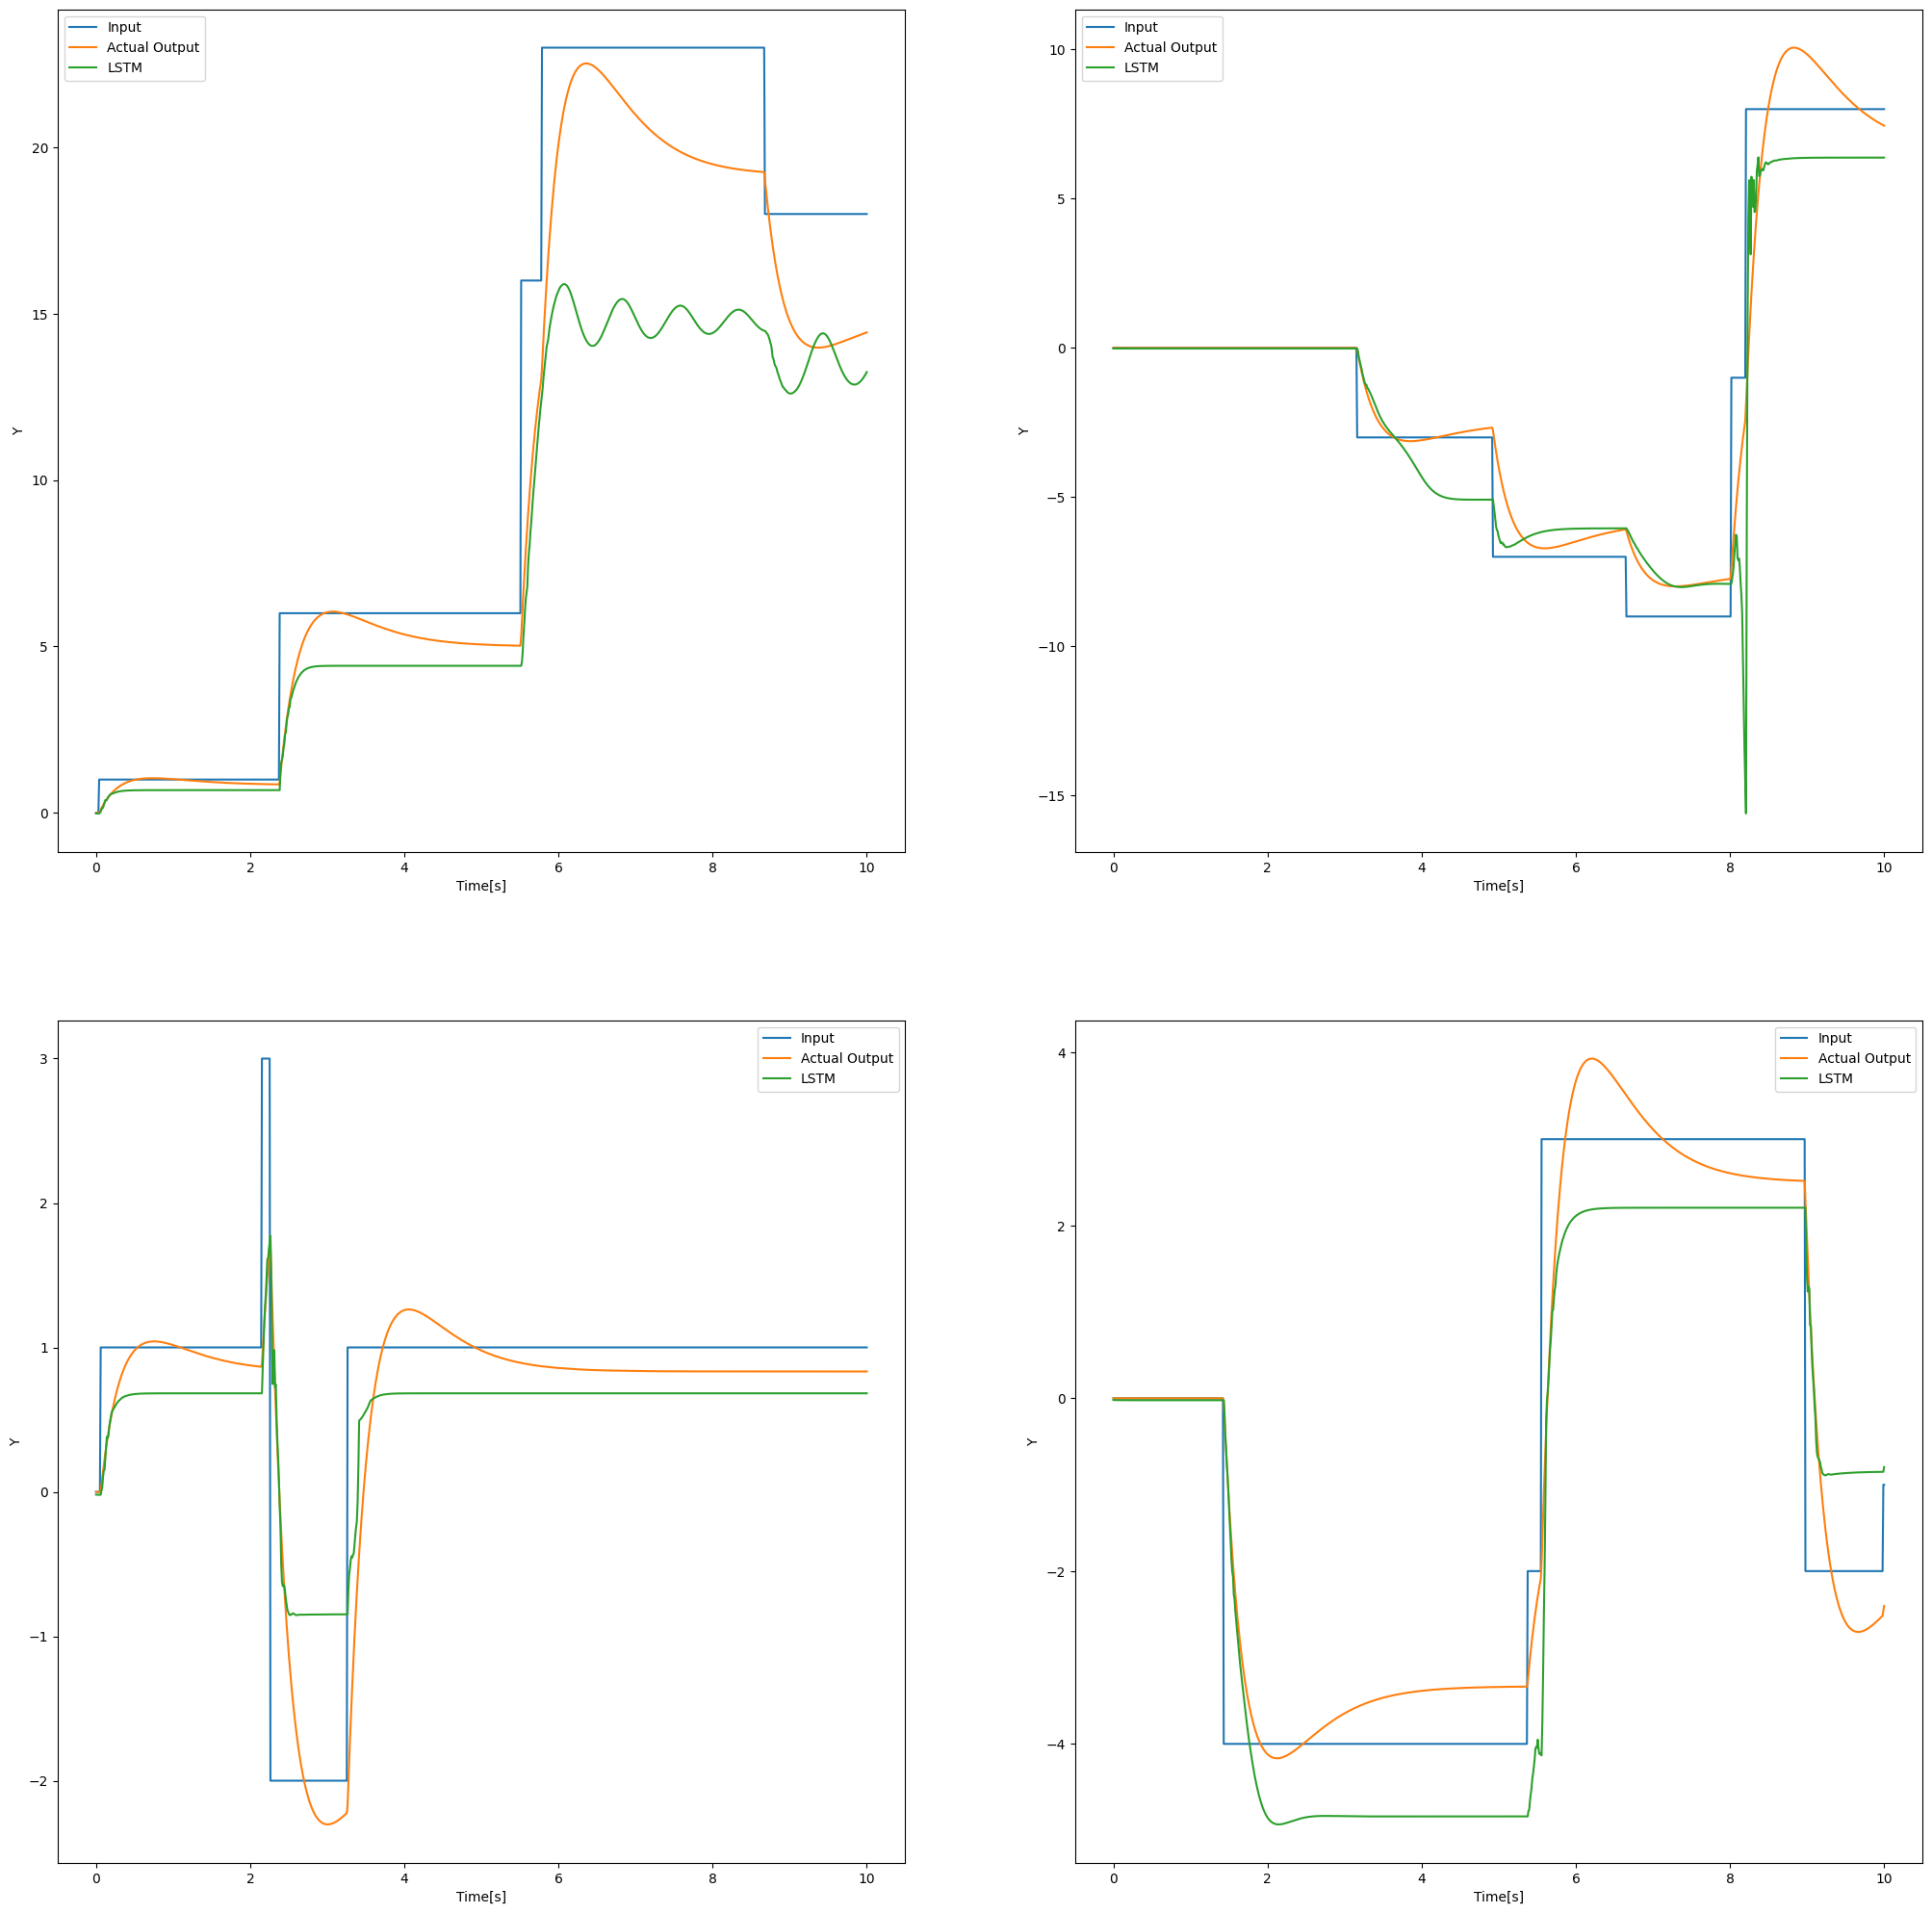

In [38]:
plt.figure(figsize=(25,25))
for i in range(4):
    t, u, y = simulations[i]
    prediction = predictions[i]
    plt.subplot(2,2,i+1)
    plt.plot(t, u)
    plt.plot(t, y)
    plt.plot(t, prediction)
    plt.xlabel('Time[s]')
    plt.ylabel('Y')
    plt.legend(['Input', 'Actual Output', 'LSTM'])
    i+=1
plt.show()

# 6. Save models

In [ ]:
name = 'rnn'

In [245]:
models[name].save(f'models/{name}')

INFO:tensorflow:Assets written to: models/rnn/assets


INFO:tensorflow:Assets written to: models/rnn/assets


In [234]:
for name, model in models.items():
    model.save(f'models/{name}')

INFO:tensorflow:Assets written to: models/dnn/assets


INFO:tensorflow:Assets written to: models/cnn/assets


INFO:tensorflow:Assets written to: models/cnn/assets


INFO:tensorflow:Assets written to: models/rnn/assets


INFO:tensorflow:Assets written to: models/rnn/assets


INFO:tensorflow:Assets written to: models/lstm/assets


INFO:tensorflow:Assets written to: models/lstm/assets


INFO:tensorflow:Assets written to: models/custom/assets


INFO:tensorflow:Assets written to: models/custom/assets
